#### K均值聚类
- 优点：容易实现。
- 缺点：可能收敛到局部最小值，在大规模数据集上收敛较慢。
- 适用数据类型：数值型数据。

### K-均值聚类的一般流程
（1）收集数据：可以使用任意方法。  
（2）准备数据：需要数值型数据来计算距离，也可以将标称型数据映射为二值型数据再用于距离计算。  
（3）分析数据：可以使用任意方法。  
（4）训练算法：不适用于无监督学习，即无监督学习没有训练过程。  
（5）测试算法：应用聚类算法、观察结果。可以使用量化的误差指标如误差平方和来评价算法的结果。  
（6）使用算法：可以用于所希望的任何应用。通常情况下，簇质心可以代表整个簇的数据来做出决策。

In [10]:
import numpy as np

"""
函数说明:加载函数

Parameters:
    fileName - 文件名
Returns:
    dataMat- 数据集
"""
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine))
        dataMat.append(fltLine)
    return dataMat

"""
函数说明:计算两个向量的欧式距离

Parameters:
    vecA - 向量A
    vecB - 向量B
Returns:
    向量A和向量B的欧式距离 
"""
def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA-vecB,2)))

"""
函数说明:为给定数据集构建一个包含k个随机质心的集合

Parameters:
    dataSet - 数据集
    k - 簇的数目
Returns:
    centroids -  质心矩阵
"""
def randCent(dataSet, k):
    n = np.shape(dataSet)[1]    #返回数据集的列数
    centroids = np.mat(np.zeros((k,n)))     #初始化质心矩阵
    for j in range(n):      #遍历数据集的每一维
        minJ = min(dataSet[:,j])    #找到数据集每一维的最小值
        rangeJ = float(max(dataSet[:,j])-minJ)  #每一维的最大值减最小值
        centroids[:,j] = np.mat(minJ+rangeJ*np.random.rand(k,1))    #k个质心向量的第j维数据值随机为位于(最小值，最大值)内的某一值
    return centroids    #返回初始化得到的k个质心向量

In [11]:
"""
函数说明:k均值聚类算法

Parameters:
    dataSet - 数据集
    k - 簇的数目
    distMeas - 距离计算方法
    createCent - 质心初始化方法
Returns:
    centroids -  质心矩阵
    clusterAssment - 簇分配结果矩阵
"""
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = np.shape(dataSet)[0]    #获取数据集样本数
    clusterAssment = np.mat(np.zeros((m,2)))    #初始化一个(m,2)的矩阵，存储最小距离和对应的索引
    centroids = createCent(dataSet,k)   #创建初始的k个质心向量
    clusterChanged = True    #聚类结果是否发生变化的布尔类型
    while clusterChanged:   #只要聚类结果一直发生变化，就一直执行聚类算法，直至所有数据点聚类结果不变化
        clusterChanged = False   #聚类结果变化布尔类型置为false
        for i in range(m):  #遍历数据集每一个样本向量
            minDist = np.inf; minIndex = -1 #初始化最小距离为正无穷；最小距离对应索引为-1
            for j in range(k):  #循环k个类的质心
                distJI = distMeas(centroids[j,:],dataSet[i,:])  #计算数据点到质心的欧氏距离
                if distJI < minDist:    #如果距离小于当前最小距离
                    minDist = distJI; minIndex = j  #当前距离定为当前最小距离；最小距离对应索引对应为j(第j个类)
            #当前聚类结果中第i个样本的聚类结果发生变化：布尔类型置为true，继续聚类算法
            if clusterAssment[i,0] != minIndex: clusterChanged = True   
            clusterAssment[i,:] = minIndex,minDist**2   #更新当前变化样本的聚类结果和平方误差
        #print(centroids)    #打印k-均值聚类的质心
        for cent in range(k):   #遍历每一个质心
            ptsInClust = dataSet[np.nonzero(clusterAssment[:,0].A == cent)[0]] #将数据集中所有属于当前质心类的样本通过条件过滤筛选出来
            centroids[cent,:] = np.mean(ptsInClust, axis=0) #计算这些数据的均值（axis=0：求列的均值），作为该类质心向量
    return centroids,clusterAssment #返回k个聚类，聚类结果及误差

In [12]:
dataMat = np.mat(loadDataSet('data/testSet.txt'))
centroids,clusterAssment = kMeans(dataMat,4)

#### 二分K-均值算法
二分K-means算法首先将所有点作为一个簇，然后将簇一分为二。之后选择其中一个簇继续进行划分，选择哪一个簇取决于对其进行划分是否能够最大程度的降低SSE的值。上述划分过程不断重复，直至划分的簇的数目达到用户指定的值为止。

In [16]:
"""
函数说明:二分K-均值聚类算法

Parameters:
    dataSet - 数据集
    k - 簇的数目
    distMeas - 距离计算方法
Returns:
    centroids -  质心矩阵
    clusterAssment - 簇分配结果矩阵
"""
def biKmeans(dataSet,k,distMeas = distEclud):
    m = np.shape(dataSet)[0]    #获取数据集样本数
    clusterAssment = np.mat(np.zeros((m,2)))    #初始化一个(m,2)的矩阵，存储最小距离和对应的索引
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]    #获取数据集每一列数据的均值，组成一个长为列数的列表
    centList = [centroid0]  #当前聚类列表为将数据集聚为一类
    for j in range(m):  #遍历每个数据集样本
        clusterAssment[j,1] = distMeas(np.mat(centroid0),dataSet[j,:])**2   #计算当前聚为一类时各个数据点距离质心的平方距离
    while (len(centList)<k):    #循环，直至二分k-均值达到k类为止
        lowestSSE = np.inf  #将当前最小平方误差置为正无穷
        for i in range(len(centList)):  #遍历当前每个聚类
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:,0].A==i)[0],:] #通过数组过滤筛选出属于第i类的数据集合
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas) #对该类利用二分k-均值算法进行划分，返回划分后结果，及误差
            sseSplit = np.sum(splitClustAss[:,1]) #计算该类划分后两个类的误差平方和
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:,0].A != i)[0],1]) #计算数据集中不属于该类的数据的误差平方和
            print("sseSplit, and notSplit:", sseSplit, sseNotSplit) #打印这两项误差值
            if (sseSplit+sseNotSplit) < lowestSSE: #划分第i类后总误差小于当前最小总误差
                bestCentToSplit = i #第i类作为本次划分类
                bestNewCents = centroidMat #第i类划分后得到的两个质心向量
                bestClustAss = splitClustAss.copy() #复制第i类中数据点的聚类结果即误差值
                lowestSSE = sseSplit + sseNotSplit  #将划分第i类后的总误差作为当前最小误差
        # 数组过滤筛选出本次2-均值聚类划分后类编号为1数据点，将这些数据点类编号变为
        # 当前类个数+1，作为新的一个聚类
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList)
        # 同理，将划分数据集中类编号为0的数据点的类编号仍置为被划分的类编号，使类编号
        # 连续不出现空缺
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        # 打印本次执行2-均值聚类算法的类
        print("the bestCentToSplit is:", bestCentToSplit)
        # 打印被划分的类的数据个数
        print("the len of bestClustAss is: ", len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]   #更新质心列表中的变化后的质心向量
        centList.append(bestNewCents[1,:].tolist()[0])  #添加新的类的质心向量
        # 更新clusterAssment列表中参与2-均值聚类数据点变化后的分类编号，及数据该类的误差平方
        clusterAssment[np.nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:] = bestClustAss
    # 返回聚类结果
    return np.mat(centList),clusterAssment

#### 示例：对于地理数据应用二分K-均值算法
（1）收集数据：使用Yahoo!PlaceFinder API收集数据。  
（2）准备数据：只保留经纬度信息。  
（3）分析数据：使用Matplotlib来构建一个二维数据图，其中包含簇与地图。  
（4）训练算法：不适用于无监督学习，即无监督学习没有训练过程。  
（5）测试算法：使用biKmeans()函数。  
（6）使用算法：最后的输出是包含簇及簇中心的地图。

In [ ]:
#Yahoo！PlaceFinder API
#导入urllib
import urllib
import urllib.request
#导入json模块
import json

"""
函数说明:利用地名，城市获取位置经纬度函数

Parameters:
    stAddress - 街道地址
    city - 城市名
Returns:
    json解析后的数据字典
"""
def geoGrab(stAddress,city):
    #获取经纬度网址
    apiStem='http://where.yahooapis.com/geocode?'
    #初始化一个字典，存储相关参数
    params={}
    #返回类型为json
    params['flags']='J'
    #参数appid
    params['appid']='ppp68N8t'
    #参数地址位置信息
    params['location']=('%s %s' %(stAddress,city))
    #利用urlencode函数将字典转为URL可以传递的字符串格式
    url_params=urllib.parse.urlencode(params)
    #组成完整的URL地址api
    yahooApi=apiStem+url_params
    #打印该URL地址
    print('%s',yahooApi)
    #打开URL，返回json格式的数据
    c=urllib.request.urlopen(yahooApi)
    #返回json解析后的数据字典
    return json.load(c.read())

from time import sleep
"""
函数说明:具体文本数据批量地址经纬度获取函数

Parameters:
    fileName - 文件名
Returns:
    无
"""
def massPlaceFind(fileName):
    #新建一个可写的文本文件，存储地址，城市，经纬度等信息
    fw=open('places.txt','wb+')
    #遍历文本的每一行
    for line in open(fileName).readlines():
        #去除首尾空格
        line =line.strip()
        #按tab键分隔开
        lineArr=line.split('\t')
        #利用获取经纬度函数获取该地址经纬度
        retDict=geoGrab(lineArr[1],lineArr[2])
        #如果错误编码为0，表示没有错误，获取到相应经纬度
        if retDict['ResultSet']['Error']==0:
            #从字典中获取经度
            lat=float(retDict['ResultSet']['Results'][0]['latitute'])
            #维度
            lng=float(retDict['ResultSet']['Results'][0]['longitute'])
            #打印地名及对应的经纬度信息
            print('%s\t%f\t%f'%(lineArr[0],lat,lng))
            #将上面的信息存入新的文件中
            fw.write('%s\t%f\t%f\n' %(line,lat,lng))
        #如果错误编码不为0，打印提示信息
        else: print('error fetching')
        #为防止频繁调用API，造成请求被封，使函数调用延迟一秒
        sleep(1)
    #文本写入关闭
    fw.close()

- 由于书上给出的yahooAPI的baseurl已经改变，所以运行会报503错误，因为已经提供了place.txt数据，故不纠结此段了。。。
#### 示例：对地理坐标进行聚类

In [14]:
"""
函数说明:球面距离计算

Parameters:
    vecA - 向量A
    vecB - 向量B
Returns:
    球面余弦定理计算两个经纬度之间的距离
"""
def distSLC(vecA,vecB):
    #sin()和cos()以弧度未输入，将float角度数值转为弧度，即*pi/180
    a=np.sin(vecA[0,1]*np.pi/180)*np.sin(vecB[0,1]*np.pi/180)
    b=np.cos(vecA[0,1]*np.pi/180)*np.cos(vecB[0,1]*np.pi/180)* \
      np.cos(np.pi*(vecB[0,0]-vecA[0,0])/180)
    return np.arccos(a+b)*6371.0

import matplotlib
import matplotlib.pyplot as plt

"""
函数说明:将文本文件中的俱乐部进行聚类并画出结果

Parameters:
    numClust - 聚类个数，默认为5
Returns:
    无
"""
def clusterClubs(numClust=5):
    datList=[]
    #解析文本数据中的每一行中的数据特征值
    for line in open('data/places.txt').readlines():
        lineArr=line.split('\t')
        datList.append([float(lineArr[4]),float(lineArr[3])])
    datMat=np.mat(datList)
    #利用2-均值聚类算法进行聚类
    myCentroids,clusterAssing=biKmeans(datMat,numClust,distMeas=distSLC)
    #对聚类结果进行绘图
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('data/Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clusterAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

sseSplit, and notSplit: 3431.62115093 0.0
the bestCentToSplit is: 0
the len of bestClustAss is:  69
sseSplit, and notSplit: 1230.24209279 1062.02719736
sseSplit, and notSplit: 637.012501277 2369.59395357
the bestCentToSplit is: 0
the len of bestClustAss is:  53
sseSplit, and notSplit: 329.29919307 1892.34421354
sseSplit, and notSplit: 652.081187148 1230.24209279
sseSplit, and notSplit: 471.811519478 1461.95227396
the bestCentToSplit is: 1
the len of bestClustAss is:  16
sseSplit, and notSplit: 170.756708985 1482.39820334
sseSplit, and notSplit: 18.7925736762 1708.56272044
sseSplit, and notSplit: 504.268732393 1052.00626375
sseSplit, and notSplit: 235.329912121 1404.00265228
the bestCentToSplit is: 2
the len of bestClustAss is:  35


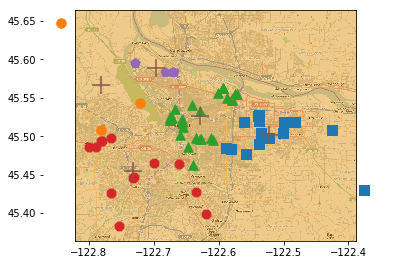

In [17]:
clusterClubs(5)